# Code for the construction and analysis of content networks

In this notebook we compile the code for constructing and analysing the content networks in the paper *Complex networks approach to curriculum analysis and subject integration: a case study on Physics and Mathematics*.

In [6]:
# needed libraries
import networkx as nx
import pandas as pd
from random import sample
import matplotlib.pyplot as plt
from scipy import stats

# Functions

def read_data(fname='network_data.csv'):
    """
    Reads the data that we have already.
    """
    df_continguts = pd.read_csv(fname,sep=',')
    return df_continguts

def full_undir_network(df):
    """
    create the undirected network from the data taking into account directed 
    and undirected relations and putting them all as undirected
    """
    g = nx.Graph()
    for index,row in df.iterrows():
        if not pd.isnull(row['Relacionat amb']):
            neighbors = row['Relacionat amb'].split(',')
            for neigh in neighbors:
                g.add_edge(row['Id'],neigh)
        if not pd.isnull(row['Necessari per']):
            neighbors = row['Necessari per'].split(',')
            for neigh in neighbors:
                g.add_edge(row['Id'],neigh)
    return g

In [12]:
# here choose which network you want to examine
# In the next three lines of code, choose only one; 
# only physics, only math or both

materia = ['Física']
materia = ['Matemàtiques II']
# materia = ['Física','Matemàtiques II']

<>:50: SyntaxWarning: invalid escape sequence '\h'
<>:58: SyntaxWarning: invalid escape sequence '\h'
<>:50: SyntaxWarning: invalid escape sequence '\h'
<>:58: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_5297/2287601019.py:50: SyntaxWarning: invalid escape sequence '\h'
  fout.write("Identificador & Matèria & Bloc & Contingut & Grau & Proximitat & Intermediació\\\\ \hline \n")
/tmp/ipykernel_5297/2287601019.py:58: SyntaxWarning: invalid escape sequence '\h'
  fout.write(node+" & "+mat+" & "+bloc+" & "+cont+" & " +str(row['degree'])+" & "+str(round(row['closeness'],3))+" & "+str(round(row['betweenness'],3))+" \\\\ \hline \n")


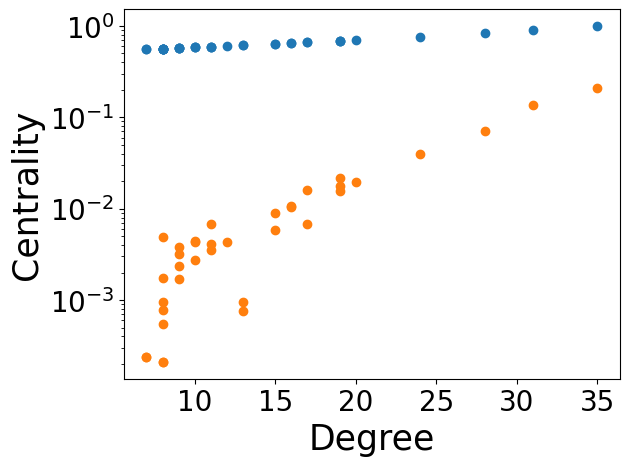

In [13]:
df_continguts = read_data()

df_continguts = df_continguts[df_continguts['Matèria'].isin(materia)]
g = full_undir_network(df_continguts)
nodes = list(g.nodes())
if materia == ['Matemàtiques II']:
    aux = 'F'
elif materia == ['Física']:
    aux = 'M'
else:
    aux = 'N'
for node in nodes:
    mat = node[0]
    if mat == aux:
        g.remove_node(node)
bloc_dict = dict()
mat_dict = dict()
cont_dict = dict()
for node in g.nodes():
    # print(node,list(df_fisica[df_fisica['Id']==node]['Bloc']))
    bloc_dict[node] = list(df_continguts[df_continguts['Id']==node]['Bloc'])[0]
    mat_dict[node] = list(df_continguts[df_continguts['Id']==node]['Matèria'])[0]
    cont_dict[node] = list(df_continguts[df_continguts['Id']==node]['Contingut'])[0]
bloc_list = list(set(bloc_dict.values()))
color_dict = dict()
clist = []
for node in g.nodes():
    color_dict[node] = bloc_list.index(bloc_dict[node])
    clist.append(bloc_list.index(bloc_dict[node])) 
nx.set_node_attributes(g,bloc_dict,name='Bloc')
nx.set_node_attributes(g,mat_dict,name='Materia')
nx.set_node_attributes(g,cont_dict,name='Contingut')
nx.set_node_attributes(g,color_dict,name='color')
deg = dict(nx.degree(g))
df_centralities = pd.DataFrame.from_dict({
    'node': list(deg.keys()),
    'degree': list(deg.values())
})
# closeness
cc = nx.closeness_centrality(g)
df_centralities['closeness'] = df_centralities['node'].map(cc)
# betweenness
bc = nx.betweenness_centrality(g)
df_centralities['betweenness'] = df_centralities['node'].map(bc)

df_centralities = df_centralities.sort_values('degree', ascending=False)
df_centralities.head(10)
# %%
fout = open('table_degree_'+'_'.join(materia)+'.tex','w')
fout.write("Identificador & Matèria & Bloc & Contingut & Grau & Proximitat & Intermediació\\\\ \hline \n")
i=0
for index,row in df_centralities.iterrows():
    if i < 10:
        node = row['node']
        mat = mat_dict[node]
        bloc = bloc_dict[node]
        cont = cont_dict[node]
        fout.write(node+" & "+mat+" & "+bloc+" & "+cont+" & " +str(row['degree'])+" & "+str(round(row['closeness'],3))+" & "+str(round(row['betweenness'],3))+" \\\\ \hline \n")
        i+=1

fout.close()
plt.scatter(list(df_centralities['degree']), list(df_centralities['closeness']), label='Closeness')
plt.scatter(list(df_centralities['degree']), list(df_centralities['betweenness']), label='Betweenness')
plt.yscale('log')
plt.xlabel('Degree', fontsize=25)
plt.ylabel('Centrality', fontsize=25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
if materia not in [['Física'], ['Matemàtiques II']]:
    plt.legend(fontsize = 20)
plt.savefig('ENG_centralitats_'+'_'.join(['_'.join(x.split()) for x in materia])+'.png',bbox_inches='tight')
plt.savefig('ENG_centralitats_'+'_'.join(['_'.join(x.split()) for x in materia])+'.pdf',bbox_inches='tight')


df_centralities = df_centralities.sort_values('degree', ascending=False)
ranking_deg = list(df_centralities['degree'])

ranking_closeness = list(df_centralities['closeness'])

ranking_betweenness = list(df_centralities['betweenness'])

df_rankings = pd.DataFrame([ranking_deg,ranking_closeness,ranking_betweenness])
df_rankings = df_rankings.transpose()
df_rankings.columns = ['Degree', 'Closeness', 'Betweenness']


corr_rankings = df_rankings.corr(method='spearman')

fout = open('corr_centralitats_'+'_'.join(['_'.join(x.split()) for x in materia])+'.txt','w')

res_deg_Betw = stats.spearmanr([ranking_deg,ranking_betweenness],axis=1)
fout.write('deg-Betw:'+str(res_deg_Betw.statistic)+' '+str(res_deg_Betw.pvalue)+'\n')
res_deg_close = stats.spearmanr([ranking_deg,ranking_closeness],axis=1)
fout.write('deg-close:'+str(res_deg_close.statistic)+' '+str(res_deg_close.pvalue)+'\n')
res_close_Betw = stats.spearmanr([ranking_closeness,ranking_betweenness],axis=1)
fout.write('close-Betw:'+str(res_close_Betw.statistic)+' '+str(res_close_Betw.pvalue)+'\n')

fout.close()
